This notebook picks out rating information from brewery page.

In [502]:
import getUntappdURL as getU

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep

import requests
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

### Import brewery databse

In [6]:
dfBrewery = pd.read_csv('brews/breweries_final.csv')

In [7]:
dfBrewery.head()

,Unnamed: 0,brewID,brewery,address,city,state,neighborhood,website,features,coord,coord2,inChicago,latitude,longitude,hasTapRoom,hasTour,hasKitchen,untappdURL
0,0,1hd3,18th Street Brewery – Hammond,5417 N. Oakley Ave.,Hammond,IN,NaN,http://www.18thstreetbrewery.com/,kitchen & beer,"-87.517525,41.6156",98416802.0,no,41.615600,-87.517525,no,no,yes,https://untappd.com/18thStreetBrewery
1,1,1hy5,18th Street Brewery – Gary,5725 Miller Ave.,Gary,IN,NaN,http://www.18thstreetbrewery.com/,kitchen & beer,"-87.26886,41.599365",98428122.0,no,41.599365,-87.268860,no,no,yes,https://untappd.com/18thStreetBrewery
2,2,2W.3,25 West Brewing Co.,2 Stratford Dr.,Bloomingdale,IL,NaN,https://www.facebook.com/25WestBrew/,NaN,"-88.11923,41.950455",112710728.0,no,41.950455,-88.119230,no,no,no,https://untappd.com/w/25-west-brewing-co/391402
3,3,3 .2,350 Brewing Co.,7144 W. 183rd St.,Tinley Park,IL,NaN,https://350brewing.com,kitchen & beer,"-87.791595,41.55857",638598086.0,no,41.558570,-87.791595,no,no,yes,https://untappd.com/350Brewing
4,4,3l.6,3 Floyds Brewing Co.,9750 Indiana Pkwy.,Munster,IN,NaN,http://www.3floyds.com/,"kitchen & beer, tour","-87.515755,41.536514",98443594.0,no,41.536514,-87.515755,no,yes,yes,https://untappd.com/3floyds


### Get most popular beers

In [10]:
def simpleGet(url):
    """Attempts to get the content at 'url' by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None"""
    try:
        with closing(requests.get(url, stream=True)) as resp:
            if isGoodResponse(resp):
                return resp.content
            else:
                return None
    
    except RequestException as e:
        logError('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
def isGoodResponse(resp):
    """Returns True if the response seems to be HTML"""
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200
            and content_type is not None
            and content_type.find('html') > -1)

def logError(e):
    """Prints error"""
    print(e)

In [11]:
def makeSoup(url):
    """Use simple_get function to make soup from url"""
    try:
        return BeautifulSoup(simpleGet(url), 'html.parser')
    except TypeError as e:
        logError('Non-HTML content at {0} : {1}'.format(url, str(e)))
        return None

def getBeerURL(breweryURL):
    """Get the beer page URL"""
    return breweryURL + '/beer'

In [141]:
soup = makeSoup(getBeerURL(dfBrewery['untappdURL'][0]))

In [142]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script type="text/javascript">
   (window.NREUM||(NREUM={})).loader_config={xpid:"Vg4HVFBADQoFVFZbAAI="};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(15),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(s.console=!0,o.indexOf("dev")!==-1&&(s.dev=!0),o.indexOf("nr_dev")!==-1&&(s.nrDev=!0))}catch(c){}s.nrDev&&i.on("internal-error",function(t){r(t.stack)}),s.dev&&i.on("fn-err",function(t,n,e){r(e.stack)}),s.dev&&(r("NR AGENT IN DEVELOPMENT MODE"),r("flags: "+a(s,function(t,n){retu

Most basic rating info is the total number of ratings, the aggregate (average) rating, and the number of beers in Untappd.

In [366]:
def getBasicRating(url):
    """Get (average rating, number of ratings, number of beers),
    given the beer page URL"""
    soup = makeSoup(url)
    #rating is w/in tags <p class="rating"> <span class="num">
    rawRating = soup.find('p', 'rating').find('span', 'num').string
    if not rawRating: #it can be N/A. I'll record these as nan
        rating = np.nan
    else:
        rating = float(rawRating.strip('()'))
    #number of ratings is w/in <p class="raters">
    rawRaters = soup.find('p', 'raters').string
    #number of beers is w/in <p class="count">
    rawBeers = soup.find('p', 'count').string
    
    #These are strings, w/ format
    #'(#.##)', ' ###,### Ratings ', ' ### Beers '
    return (rating,
            int(rawRaters.split()[0].replace(',', '')),
            int(rawBeers.split()[0].replace(',', '')))

In [177]:
ratingDict = {}

for url in dfBrewery['untappdURL']:
    if type(url) == str: #skip nan
        sleep(10.)
        try:
            basic = getBasicRating(getBeerURL(url))
            print(url, basic)
            ratingDict[url] = basic
        except AttributeError:
            print(url, 'AttributeError')

https://untappd.com/18thStreetBrewery (3.95, 238647, 222)
https://untappd.com/18thStreetBrewery (3.95, 238647, 222)
Non-HTML content at https://untappd.com/w/25-west-brewing-co/391402/beer : object of type 'NoneType' has no len()
https://untappd.com/w/25-west-brewing-co/391402 AttributeError
https://untappd.com/350Brewing (3.78, 36510, 250)
https://untappd.com/3floyds (4.03, 1686780, 314)
https://untappd.com/5Rabbit (3.63, 146395, 142)
https://untappd.com/51stWardBeer (3.72, 15150, 50)
https://untappd.com/9thHourBrewing (4.13, 175, 39)
https://untappd.com/AllRiseBrewing (3.59, 10590, 30)
https://untappd.com/AfterthoughtBrewing (4.34, 1395, 41)
https://untappd.com/AlterBrewing_Company (3.75, 32251, 41)
https://untappd.com/AndersonvilleBrewing (3.3, 4705, 81)
https://untappd.com/AncientOwlBrewing (3.92, 27, 3)
https://untappd.com/ALULUBrewPub (3.56, 2427, 38)
https://untappd.com/Aleman (3.69, 5892, 50)
https://untappd.com/ArrowheadAles (3.75, 7877, 84)
https://untappd.com/AlarmistBrewing

In [367]:
for url in ratingDict.keys():
    if type(ratingDict[url]) != tuple:
        basic = getBasicRating(getBeerURL(url))
        print(url, basic)
        ratingDict[url] = basic

https://untappd.com/LivingProofBrewing (nan, 48, 14)
https://untappd.com/PresentTenseFineAles (nan, 26, 17)
https://untappd.com/StupidHareBrews (nan, 24, 7)
Non-HTML content at https://untappd.com/w/25-west-brewing-co/391402/beer : object of type 'NoneType' has no len()


AttributeError: 'NoneType' object has no attribute 'find'

I need to fiddle with the session attributes to take care of the failures.

In [373]:
def simpleGetSession(url, session):
    """Attempts to get the content at 'url' by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None"""
    try:
        with closing(session.get(url, stream=True)) as resp:
            if isGoodResponse(resp):
                return resp.content
            else:
                return None
    
    except RequestException as e:
        logError('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
def makeSoupSession(url, session):
    """Use simple_get function to make soup from url"""
    try:
        return BeautifulSoup(simpleGetSession(url, session), 'html.parser')
    except TypeError as e:
        logError('Non-HTML content at {0} : {1}'.format(url, str(e)))
        return None

def getBreweryURLSession(name, session):
    """Returns the Untappd brewery page URL from name"""
    if name == '': #recursion did not work
        return None
    elif name in nameDict: #convert exceptional cases
        name = nameDict[name]
        
    try:
        url = searchURL(name)
        soup = makeSoupSession(url, session)
        #get the result part of the HTML
        result = soup.find("div", {"class": "results-container"})
        #go to the top brewery in the search
        nameTag = result.find("p", {"class": "name"})
        #get the href
        href = nameTag.find("a")['href']
        return 'https://untappd.com' + href
    except AttributeError: #no search result
        #try without the last word (recursion)
        shorterName = ' '.join(name.split()[:-1])
        return getBreweryURLSession(shorterName, session)
    
def getBasicRatingSession(url, session):
    """Get (average rating, number of ratings, number of beers),
    given the beer page URL"""
    soup = makeSoupSession(url, session)
    #rating is under <p class="rating"> <span class="num">
    rawRating = soup.find('p', 'rating').find('span', 'num').string
    if not rawRating: #it can be N/A. I'll record these as nan
        rating = np.nan
    else: #otherwise, strip '()'
        rating = float(rawRating.strip('()'))
    #number of ratings is under <p class="raters">
    rawRaters = soup.find('p', 'raters').string
    #number of beers is under <p class="
    rawBeers = soup.find('p', 'count').string
    
    #The last 2 are strings w/ formats ' ###,### Ratings ', ' ### Beers '
    return (rating,
            int(rawRaters.split()[0].replace(',', '')),
            int(rawBeers.split()[0].replace(',', '')))

In [377]:
#URLs that didn't work
failedURLs = set(dfBrewery['untappdURL']) - set(ratingDict.keys())

In [378]:
with requests.session() as s:
    #pretend to be Chrome...
    s.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36'})
    for url in failedURLs:
        if type(url) == str: #ignore nan
            sleep(10.)
            try:
                basic = getBasicRatingSession(getBeerURL(url), s)
                print(url, basic)
                ratingDict[url] = basic
            except AttributeError:
                print(url, 'AttributeError')

https://untappd.com/w/25-west-brewing-co/391402 (nan, 16, 2)


In [225]:
dfRating = pd.DataFrame.from_dict(ratingDict, orient='index')

In [235]:
dfRating.columns = ['rating', 'raters', 'beers']

In [505]:
dfRating.to_csv('brews/brewery_ratings.csv')

### Get beer ratings

Test for Goose Island first (page should be full). Then test a smaller brewery that doesn't have many beers.

In [270]:
dfBrewery[dfBrewery['brewery'] == 'Goose Island Beer Co.']

,Unnamed: 0,brewID,brewery,address,city,state,neighborhood,website,features,coord,coord2,inChicago,latitude,longitude,hasTapRoom,hasTour,hasKitchen,untappdURL
77,77,Gs.2,Goose Island Beer Co.,1800 W. Fulton St.,Chicago,IL,Near West Side,http://www.gooseisland.com/,"tap room, tour","-87.6721,41.886852",111765032.0,yes,41.886852,-87.6721,yes,yes,no,https://untappd.com/gooseisland


In [271]:
soup = makeSoup('https://untappd.com/gooseisland/beer')

In [272]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script type="text/javascript">
   (window.NREUM||(NREUM={})).loader_config={xpid:"Vg4HVFBADQoFVFZbAAI="};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(15),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(s.console=!0,o.indexOf("dev")!==-1&&(s.dev=!0),o.indexOf("nr_dev")!==-1&&(s.nrDev=!0))}catch(c){}s.nrDev&&i.on("internal-error",function(t){r(t.stack)}),s.dev&&i.on("fn-err",function(t,n,e){r(e.stack)}),s.dev&&(r("NR AGENT IN DEVELOPMENT MODE"),r("flags: "+a(s,function(t,n){retu

In [276]:
beerList = soup.findAll('div', 'beer-details')

In [275]:
len(beerList)

25

The maximum number of beers on the page is 25.

In [279]:
beerList[0]

<div class="beer-details"> <p class="name"><a href="/b/goose-island-beer-co-goose-ipa/1353">Goose IPA</a></p> <p class="style">IPA - English</p> <p class="desc desc-half-1353">Our India Pale Ale recalls a time when ales shipped from England to India were highly hopped to preserve their distinct taste during the long journey.… <a class="read-more-beerlist track-click" data-bid="1353" data-href=":readmorebeer" data-track="brewerylist" href="#">Read More</a> </p> <p class="desc desc-full-1353" style="display: none;">Our India Pale Ale recalls a time when ales shipped from England to India were highly hopped to preserve their distinct taste during the long journey. The result is a hop lover’s dream with a fruity aroma, set off by a dry malt middle, and long hop finish. <a class="read-less-beerlist track-click" data-bid="1353" data-href=":readlessbeer" data-track="brewerylist" href="#">Read Less</a></p> </div>

This contains the beer name, style, and description, but not the rating.

In [290]:
ratingList = soup.findAll('div', 'details')

In [292]:
len(ratingList)

26

This contains 1 extra, and it's the 1st element, which is about the brewery rating.

In [291]:
ratingList[0]

<div class="details brewery claimed"> <p class="rating"> <span class="rating small r375"></span> <span class="num">(3.84)</span> </p><p class="raters"> 3,461,156 Ratings </p><p class="count"> 839 Beers </p><p class="date"> Added 10/01/10 </p><p class="claim"> <a class="tip track-click" data-href=":claimedsticker" data-track="brewery" href="https://untappd.com/breweries" title="This brewery has been claimed and is officially managed.">Official</a> </p> </div>

In [293]:
ratingList[1]

<div class="details"> <p class="abv"> 5.9% ABV </p><p class="ibu"> 55 IBU </p><p class="rating"> <span class="rating small r350"></span> <span class="num">(3.54)</span> </p><p class="raters"> 412,303 Ratings </p><p class="date"> Added 08/21/10 </p> </div>

Write functions to extract 1. name, 2. style, 3. ABV, 4. IBU, 5. rating, 6. number of ratings, from the HTML.

In [344]:
def getBeerTags(soup):
    """Get 'beer-details' tags and 'details' tags from /beer page,
    omitting the first item found for 'details', because this is
    actually 'details brewery claimed' tag."""
    return (soup.findAll('div', 'beer-details'),
            soup.findAll('div', 'details')[1:])

In [412]:
def getBeerRatingFromTags(tag1, tag2):
    """Given 'beer-details' tag and 'details' tag for a beer,
    get (name, style, ABV, IBU, rating, number of ratings)."""
    name      = tag1.find('p', 'name').text
    style     = tag1.find('p', 'style').text
    rawABV    = tag2.find('p', 'abv').text
    rawIBU    = tag2.find('p', 'ibu').text
    rawRating = tag2.find('p', 'rating').text
    rawRaters = tag2.find('p', 'raters').text
    #the last 4 needs parsing
    try: #read off # from ' #% ABV '
        ABV = float(rawABV.strip().split('%')[0])
    except ValueError: # ' N/A ABV '
        ABV = np.nan
    try: #read off # from ' # IBU '
        IBU = float(rawIBU.split()[0])
    except ValueError: # ' N/A IBU '
        IBU = np.nan
    try: #read off '  (#) '
        rating = float(rawRating.strip().strip('()'))
    except ValueError: # '  (N/A) '
        rating = np.nan
    try: #read off ' # Ratings '
        raters = float(rawRaters.split()[0].replace(',', ''))
    except ValueError:
        raters = np.nan
    return (name, style, ABV, IBU, rating, raters)

In [434]:
def getBeerRatings(url):
    """Get the list of up to 25 most popular beers for a brewery,
    where each entry is (name, style, ABV, IBU, rating, number of ratings)"""
    if not url: #no URL
        return [] #no beers
    #make soup from the beer page
    soup = makeSoup(url + '/beer')
    #get the lists of tags for beers and their ratings
    list1, list2 = getBeerTags(soup)
    return [getBeerRatingFromTags(tag1, tag2)
            for tag1, tag2 in zip(list1, list2)]

In [435]:
def getBeerRatingsSession(url, session):
    """Get the list of up to 25 most popular beers for a brewery,
    where each entry is (name, style, ABV, IBU, rating, number of ratings)"""
    if not url: #no URL
        return [] #no beers
    #make soup from the beer page
    soup = makeSoupSession(url + '/beer', session)
    #get the lists of tags for beers and their ratings
    list1, list2 = getBeerTags(soup)
    return [getBeerRatingFromTags(tag1, tag2)
            for tag1, tag2 in zip(list1, list2)]

In [410]:
beerRatingDict = {}

In [423]:
for url in dfBrewery['untappdURL']:
    if url not in beerRatingDict:
        try:
            beerRatingDict[url] = getBeerRatings(url)
            print(url, len(beerRatingDict[url]))
            sleep(10.)
        except AttributeError:
            print(url, 'Attribute Error')
        except TypeError:
            print(url, 'Type Error')

Non-HTML content at https://untappd.com/w/25-west-brewing-co/391402/beer : object of type 'NoneType' has no len()
https://untappd.com/w/25-west-brewing-co/391402 Attribute Error
Non-HTML content at https://untappd.com/w/band-of-bohemia/201836/beer : object of type 'NoneType' has no len()
https://untappd.com/w/band-of-bohemia/201836 Attribute Error
Non-HTML content at https://untappd.com/w/blue-island-beer-company/120917/beer : object of type 'NoneType' has no len()
https://untappd.com/w/blue-island-beer-company/120917 Attribute Error
nan Type Error
https://untappd.com/BuckleDownBrewing 25
https://untappd.com/BucketListBrewingCompany 25
https://untappd.com/BulldogBrewingCoIndiana 25
https://untappd.com/BallastPoint 25
https://untappd.com/BurntCity 25
https://untappd.com/BirreriaEatalyChicago 25
https://untappd.com/BegyleBrewing 25
https://untappd.com/chicagobeerco 12
https://untappd.com/CademonBrewing 25
https://untappd.com/CahootsBrewing 14
https://untappd.com/ChurchStreetBrewingCo 23


Get around the 429 response.

In [436]:
with requests.session() as s:
    #pretend to be Chrome...
    s.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36'})
    for url in dfBrewery['untappdURL']:
        if url not in beerRatingDict:
            try:
                beerRatingDict[url] = getBeerRatingsSession(url, s)
                print(url, len(beerRatingDict[url]))
                sleep(10.)
            except AttributeError:
                print(url, 'Attribute Error')

https://untappd.com/w/25-west-brewing-co/391402 2
https://untappd.com/w/band-of-bohemia/201836 25
https://untappd.com/w/blue-island-beer-company/120917 25
 0
https://untappd.com/w/staatliches-hofbra-uhaus-ma-1-4-nchen/5566 25
https://untappd.com/w/itasca-brewing-company/40906 25
https://untappd.com/w/macushla-brewing-co/357382 25
https://untappd.com/w/one-trick-pony/31051 25
https://untappd.com/w/stockholms/12082 25
https://untappd.com/w/woggly-square-brewing/382879 7


Make a DataFrame of beers.

In [496]:
dfBeer = pd.DataFrame()

for url in beerRatingDict:
    if beerRatingDict[url]:
        print(url, len(beerRatingDict[url]))
        dfBrewery = pd.DataFrame(beerRatingDict[url])
        #associate the brewery URL
        dfBrewery[6] = url
        #popularity rank within brewery
        dfBrewery[7] = range(1, len(dfBrewery) + 1)
        dfBeer = dfBeer.append(dfBrewery)

https://untappd.com/18thStreetBrewery 25
https://untappd.com/350Brewing 25
https://untappd.com/3floyds 25
https://untappd.com/5Rabbit 25
https://untappd.com/51stWardBeer 25
https://untappd.com/9thHourBrewing 25
https://untappd.com/AllRiseBrewing 25
https://untappd.com/AfterthoughtBrewing 25
https://untappd.com/AlterBrewing_Company 25
https://untappd.com/AndersonvilleBrewing 25
https://untappd.com/AncientOwlBrewing 3
https://untappd.com/ALULUBrewPub 25
https://untappd.com/Aleman 25
https://untappd.com/ArrowheadAles 25
https://untappd.com/AlarmistBrewing 25
https://untappd.com/ATB 25
https://untappd.com/ArgusBrewery 25
https://untappd.com/BywayBrewingCompany 25
https://untappd.com/BosackisHomeBrew 25
https://untappd.com/BBGBBreweryHopFarm 18
https://untappd.com/BlackHorizonBrewingCompany 25
https://untappd.com/BoldDogBeerCo 25
https://untappd.com/baderbrau 25
https://untappd.com/BlueNoseAdmin 19
https://untappd.com/BuffaloCreekBrewing 12
https://untappd.com/bangingavel 23
https://untappd

In [497]:
dfBeer.head()

,0,1,2,3,4,5,6,7
0,Sex and Candy,IPA - American,7.5,NaN,3.83,10286.0,https://untappd.com/18thStreetBrewery,1
1,Hunter,Stout - Milk / Sweet,8.0,NaN,4.03,8453.0,https://untappd.com/18thStreetBrewery,2
2,Rise of the Angels,IPA - Imperial / Double,7.7,NaN,3.95,8343.0,https://untappd.com/18thStreetBrewery,3
3,Temporal Purgatory,Pale Ale - American,5.9,NaN,3.91,7599.0,https://untappd.com/18thStreetBrewery,4
4,Candi Crushable,IPA - Session / India Session Ale,5.5,NaN,3.75,6949.0,https://untappd.com/18thStreetBrewery,5


In [498]:
dfBeer.columns = ['name', 'style', 'ABV', 'IBU', 'rating', 'raters', 'brewery_URL', 'rank']

In [499]:
dfBeer = dfBeer.set_index('name')

In [500]:
dfBeer.head()

,style,ABV,IBU,rating,raters,brewery_URL,rank
name,,,,,,,
Sex and Candy,IPA - American,7.5,NaN,3.83,10286.0,https://untappd.com/18thStreetBrewery,1
Hunter,Stout - Milk / Sweet,8.0,NaN,4.03,8453.0,https://untappd.com/18thStreetBrewery,2
Rise of the Angels,IPA - Imperial / Double,7.7,NaN,3.95,8343.0,https://untappd.com/18thStreetBrewery,3
Temporal Purgatory,Pale Ale - American,5.9,NaN,3.91,7599.0,https://untappd.com/18thStreetBrewery,4
Candi Crushable,IPA - Session / India Session Ale,5.5,NaN,3.75,6949.0,https://untappd.com/18thStreetBrewery,5


In [501]:
dfBeer.to_csv('brews/beers.csv')

### Exploring overall rating data

There's a correlation between number of raters and number of beers.

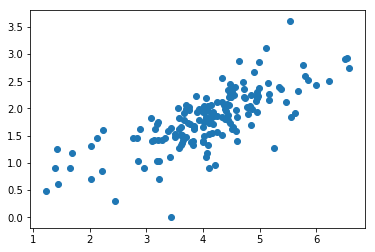

In [251]:
plt.scatter(np.log10(dfRating['raters'] + 1), np.log10(dfRating['beers'] + 1))
plt.show()

There's no obvious positive or negative relationship between the number of raters and the rating. The variance in ratings does appear to be larger for smaller breweries.

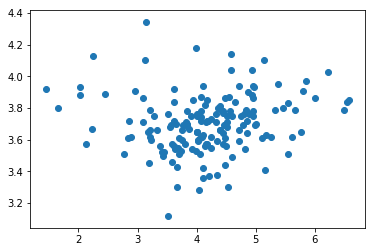

In [255]:
plt.scatter(np.log10(dfRating[dfRating['rating'] != 0]['raters'] + 1),
            dfRating[dfRating['rating'] != 0]['rating'])
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


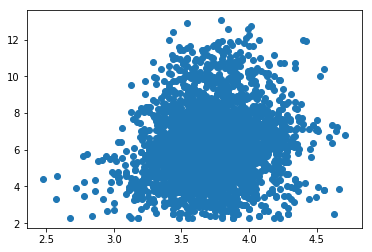

In [464]:
plt.scatter(dfBeer[4], np.log(dfBeer[5]))
plt.show()

Ah, most beers are somewhere around 3.5-4.0. There aren't too many popular and widely available beers that are terrible or amazing.